DIAMETER =                    3  / TELESCOPE diameter                            [astropy.io.fits.card]


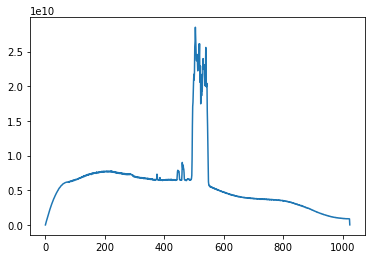

In [2]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np

path=str(os.getcwd())+'/l_297_b_-15/'

files=os.listdir(path)
stack=np.zeros(1024)

for file in files:
    hdulist=fits.open(path+file)
    hdr=hdulist[1].header
    data=hdulist[1].data
    
    #hdulist.info()
    #print(file)
    #print(repr(hdulist[1].header))
    #print(data.columns)
    #print(data['RIGHT_POL'])
    #print(data['STATUS'])
    #print('\n\n')
    
    for col in data:
        if col['STATUS'] != 'cal':
            stack+=col['RIGHT_POL']

plt.plot(stack/20)
plt.show()            

In [5]:
bonn_calib=np.loadtxt('bonn_l_207_b_-15.txt',skiprows = 4)
#print(bonn_calib)

bonn_x = bonn_calib[:,2]
bonn_y = bonn_calib[:,1]
bonn_v = bonn_calib[:,0]

xdata=np.linspace(1397.5+0.0305,1460-0.0305,dat.size)


[[-3.999200e+02 -0.000000e+00  1.422301e+03  2.107800e+01]
 [-3.988800e+02 -1.000000e-02  1.422296e+03  2.107807e+01]
 [-3.978500e+02 -1.000000e-02  1.422291e+03  2.107814e+01]
 ...
 [ 3.978500e+02 -1.000000e-02  1.418521e+03  2.113416e+01]
 [ 3.988800e+02 -1.000000e-02  1.418516e+03  2.113423e+01]
 [ 3.999200e+02 -0.000000e+00  1.418511e+03  2.113431e+01]]
